In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt 
from ckonlpy.tag import Twitter #prompt에서 pip install customized_konlpy 로 패키지 설치
from matplotlib import font_manager, rc
import seaborn as sns

pd.set_option('display.max_row',500)
pd.set_option('display.max_columns',100)
pd.set_option('display.unicode.east_asian_width',True) 

from wordcloud import WordCloud,STOPWORDS
from PIL import Image 
import collections

In [4]:
font_path = '../datasets/malgun.ttf' #내가 쓰고 싶은 폰트 파일 경로로 쓰면 됨. 현재 같은 폴더 안에 있음.
font_name = font_manager.FontProperties(fname=font_path).get_name() #get_name:폰트의 이름을 알려줌.
rc('font', family=font_name)

In [5]:
#크롤링한 데이터 파일 불러오기
#중복제거 및 널값제거 
df = pd.read_csv('../datasets/crawling_치즈볼_from20200101_to20201015.csv', index_col=0)
df.drop_duplicates(inplace=True)
df.dropna(subset=['title'],how='any',inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40644 entries, 0 to 40643
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    40644 non-null  object
 1   title   40644 non-null  object
dtypes: object(2)
memory usage: 635.2+ KB
None


In [6]:
#한국어에 사용할 토크나이저
twitter = Twitter()

c:\users\024\anaconda3\envs\machinelearning\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [7]:
#토큰화에 제외할 단어 토크나이저 딕셔너리에 추가 
twitter.add_dictionary(['뿌링클','맛스타그램', '맛스타', '푸라닭', '인스타그램', '인스타', '또래오래', '배달의민족','배민', 'instagram', '뿌링클', '고추바사삭', '뿌링뿌링','뿌링뿌링소스' ,'뿌링소스', '또래오래', '인스타 그램','먹스타그램', '황금올리브','네고왕','맘스터치','에어프라이어','블랙치즈볼','블랙알리오','청년치킨','청년피자', '레시피', '프레시웨이', 'cj프레시웨이', '장보기', '가까운', '로켓프레시', '쿠팡', '이케아', '치킨스타그램', '트레이더스'], 'Noun',force=True)

#for word in imp_wrd['important_words']:
#    twitter.add_dictionary('{}', 'Noun').format(word)
    




In [8]:
#딕셔너리 추가된 것 테스트 
twitter.morphs('일주일만에 다시 찾은 뿌링클 맛스타그램 네고왕 프레시웨이 인스타그램')

['일주일', '만에', '다시', '찾은', '뿌링클', '맛스타그램', '네고왕', '프레시웨이', '인스타그램']

In [11]:
#stopwords 현 디렉토리에 추가 해야함 
stopwords = pd.read_csv('../datasets/stopwords.csv',  encoding='CP949' ,index_col = 0) 
print(stopwords.head())
print(stopwords.tail())


  stopword
0       아
1       휴
2   아이구
3   아이쿠
4   아이고
     stopword
661      추천
662      일상
663  있습니다
664      이라
665      많이


In [14]:
#프랜차이즈 리스트 
stores = pd.read_excel('../datasets/프렌차이즈.xlsx')
stores
stores.reset_index(drop=True, inplace=True)
print(stores.info()) 
stores.columns
#stores = pd.read_csv('./stores.csv', 
#                    encoding='euc-kr', index_col=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1835 entries, 0 to 1834
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   한식      1835 non-null   object
 1   분식      455 non-null    object
 2   중식      111 non-null    object
 3   일식      201 non-null    object
 4   양식      181 non-null    object
 5   양식(외)   109 non-null    object
 6   패스트푸드   102 non-null    object
 7   치킨      519 non-null    object
 8   피자      183 non-null    object
 9   제과제빵    172 non-null    object
 10  아이스크림   40 non-null     object
 11  카페      456 non-null    object
 12  커피외음료   84 non-null     object
 13  술집      315 non-null    object
 14  기타외식    1001 non-null   object
dtypes: object(15)
memory usage: 215.2+ KB
None


Index(['한식', '분식', '중식', '일식', '양식', '양식(외)', '패스트푸드',
       '치킨', '피자', '제과제빵', '아이스크림', '카페', '커피외음료', '술집',
       '기타외식'],
      dtype='object')

In [15]:
#토큰화 및 텍스트 데이터 전처리 
cleaned_sentences = []
for sentence in df['title']:
    E_sentence = re.sub('[^a-zA-Z]',' ', sentence)  #영어텍스트만 뽑아오기
    E_sentence = E_sentence.lower()
    E_token = E_sentence.split(' ')   #영어텍스트를 띄어쓰기 기준으로 토큰화 
    K_sentence = re.sub('[^가-힣]',' ', sentence)  #한글텍스트만 뽑아오기
    K_token = twitter.nouns(K_sentence) #한글텍스트를 토큰화 및 명사만 남기기 
    K_token = pd.DataFrame(K_token, columns=['word'])   #토큰화된 한글텍스트를 다시 데이터프레임으로 만들기
    token = E_token + list(K_token['word'])    #토큰화된 한글, 영어텍스트를 합치기 
    cleaned_token = pd.DataFrame(token, columns=['word'])   #합친 것을 다시 데이터프레임으로 만들기 
    words = []
    for word in cleaned_token['word']:  #불용어 제거 
        if len(word)>1: 
            if word not in (list(stopwords['stopword'])):
                words.append(word)   
    cleaned_sentence = ' '.join(words)
    cleaned_sentences.append(cleaned_sentence)

df['cleaned_content'] = cleaned_sentences


In [11]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40644 entries, 0 to 40643
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             40644 non-null  object
 1   title            40644 non-null  object
 2   cleaned_content  40644 non-null  object
dtypes: object(3)
memory usage: 952.7+ KB
None
         date  \
0  2020-09-24   
1  2020-10-12   
2  2020-10-10   
3  2020-10-15   
4  2020-10-17   

                                                                                    title  \
0  오백예순두 번째 호기심까까  노브랜드버거 인절미치즈볼3알2900원   리뷰요청지에서...       
1  광고공구예고  안녕하세요 뚜뚜네간식 뚜맘입니다  오래 기다려주신 오크리스피 최저가공...   
2  _ 땡스피자 _ 오랜만에 먹은 땡스피자 못본 사이에 언제 이런 네가지 맛으로 즐길수...        
3  광희나는메이플버터갈릭치킨 비비큐치즈볼 bbq bbqchicken 네고왕 으로 핫한 ...              
4  배떡  방이점  로제떡볶이12인분 9000원 ...                           

                                                                     cleaned_content  
0  ver 오백 예순

In [16]:
df.to_csv('./crawling/clean_sentence_all.csv')

In [19]:
#브랜드별 검색어 리스트 불러오기
brand = pd.read_csv('../datasets/brand.csv', index_col=0)
print(brand)

     brandname                                brand
0          BHC  bhc 비에치씨 bhc치킨 비에이치씨치킨
1          BBQ        bbq 비비큐 bbq치킨 비비큐치킨
2     네네치킨            네네치킨 네네 네네볼 nene
3     맘스터치   맘스터치 맘터 mom'stouch momstouch
4       푸라닭                푸라닭 puradak 푸라닥
5     또래오래    또래오래 또래오래치킨 농협 목우촌
6   신전떡볶이      신전떡볶이 신전 신전치즈볼 신떡
7       처갓집     처갓집 처갓집양념치킨 처갓집치킨
8       풀무원                               풀무원
9       애슐리                               애슐리
10      버거킹               버거킹 burgerking 벅킹
11          CJ                       cj 씨제이 고메
12    쿠캣마켓   쿠캣마켓 쿠캣 쿠켓 쿠켓마켓 cookat
13    코스트코                      코스트코 costco
14    마켓컬리      마켓컬리 컬리 marketkurly kurly
15      이마트      이마트 emart 트레이더스 traders
16    롯데리아           롯데리아 롯리 치즈인더에그


In [14]:
# #프랜차이즈 리스트의 치킨 프랜차이즈들이 언급된 문장 갯수 구하기(개별 브랜드 확인)
# brandcount=[]
# i='롯데리아'

# store_cleaned_content = []
# dates=[]
# for sentence in df['cleaned_content']:        
#     token = sentence.split(' ')
#     tokens = pd.DataFrame(token, columns=['token'])
#     for word in (list(tokens['token'])):
#         if word in i:
#             store_cleaned_content.append(sentence)
#             dates.append(df['date'][df[df['cleaned_content']== sentence].index[0]])   
# new_df = pd.DataFrame({'date':dates, i : store_cleaned_content})
# new_df.to_csv('./crawling/brand_{}.csv'.format(i))
# b_count = new_df[i].count()
# print(i, ':', b_count)
# brandcount.append(b_count)

In [20]:
#프랜차이즈 리스트의 치킨 프랜차이즈들이 언급된 문장 갯수 구하기(브랜드 정보 추가)
brandcount=[]
for i in range(len(brand)):
    store_cleaned_content = []
    dates=[]
    for sentence in df['cleaned_content']:        
        token = sentence.split(' ')
        tokens = pd.DataFrame(token, columns=['token'])
        for word in (list(tokens['token'])):
            if word in brand['brand'][i].split(' '):
                store_cleaned_content.append(sentence)
                dates.append(df['date'][df[df['cleaned_content']== sentence].index[0]])   
    new_df = pd.DataFrame({'date':dates, brand['brandname'][i] : store_cleaned_content})
    new_df.to_csv('./crawling/brand_{}.csv'.format(i))
    b_count = new_df[brand['brandname'][i]].count()
    print(brand['brandname'][i], ':', b_count)
    brandcount.append(b_count)

BHC : 9394
BBQ : 5279
네네치킨 : 458
맘스터치 : 1354
푸라닭 : 1727
또래오래 : 710
신전떡볶이 : 423
처갓집 : 305
풀무원 : 998
애슐리 : 560
버거킹 : 179
CJ : 141
쿠캣마켓 : 325
코스트코 : 159
마켓컬리 : 53
이마트 : 380
롯데리아 : 419


In [29]:
brands = {"brandname":brand['brandname'], "count":brandcount}
df_brand = pd.DataFrame(brands)
df_brand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   brandname  17 non-null     object
 1   count      17 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [30]:
df_brand.sort_values(by=['count'], axis=0, ascending=False, inplace=True)
df_brand.reset_index(drop=True, inplace=True)
df_brand

,brandname,count
0,BHC,9394
1,BBQ,5279
2,푸라닭,1727
3,맘스터치,1354
4,풀무원,998
5,또래오래,710
6,애슐리,560
7,네네치킨,458
8,신전떡볶이,423
9,롯데리아,419


In [31]:
print(df_brand['count'].sum(axis=0)) #총 리뷰 갯수 22864


22864


c:\users\024\anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


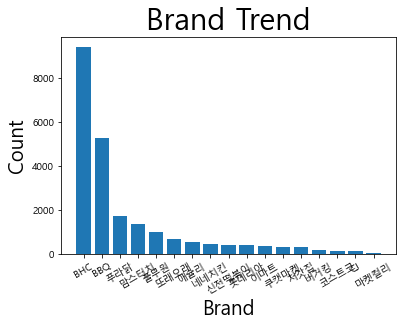

In [32]:
plt.bar(range(len(df_brand['count'])), df_brand['count'])
ax = plt.subplot()
ax.set_xticks(range(len(df_brand['brandname'])))
ax.set_xticklabels(df_brand['brandname'], rotation=30)
plt.title('Brand Trend', size=30)
plt.ylabel('Count', size=20)
plt.xlabel('Brand', size=20)
plt.show()

In [19]:
new_df = pd.read_csv('./crawling/brand_0.csv', index_col=0)

In [20]:
#필요없는 title 컬럼의 데이터들을 '치즈볼'로 통일해서 채움 -> 동일한 컬럼을 기준으로 one sentence로 합치기 위함 

new_df['title']='치즈볼'
print(new_df)

            date  \
0     2020-10-08   
1     2020-09-24   
2     2020-10-20   
3     2020-10-20   
4     2020-10-20   
...          ...   
9389  2020-09-13   
9390  2020-08-23   
9391  2020-09-17   
9392  2020-09-17   
9393  2020-09-17   

                                                                                  BHC  \
0     bhc 소사 케이크 아들 배씨 치킨 오픈 먹음 직스 러운 닭다리 치즈볼 케이크 준비...   
1     youtube chan sori asmr asmr mukbang bbq cheese...                                 
2     bhc 어제 먹방 먹스타그램 치킨 치하 저녁 치즈볼 존맛 양재 맛집 맛집......          
3     bhc 지게 고도 호텔 가기 편의점 리트리버 전하 사람 제주도 치킨 치즈볼 골드 콤...   
4                      bhc 뿌링클 감사 치즈볼 기전 메모                                 
...                                                 ...                                 
9389           bhc 친정엄마 말벌 뿌링클 치즈볼 후라이드                                 
9390  bhc 쫀득쫀득 빰치 치즈볼 레시피 태그 당한 주기 재료 찹쌀 미니 나스 믹스 모짜...   
9391  bhc bhc ooo bhc 러버 문제 가지 순서대로 힌트 사랑 보기 식음 회사.....             
9392  bhc bhc ooo bhc 러버 문제 가지 순서

In [21]:
#이름이 바뀌는 컬럼명 위치 정보로 찾기
#new_df.columns[1]


In [22]:
#one sentence 만들기
review_one_sentences = []
titles = []

for title in new_df['title'].unique():
    temp = new_df[new_df['title']==title][new_df.columns[1]]
    review_one_sentence = ' '.join(list(temp)) 
    review_one_sentences.append(review_one_sentence)
    titles.append(title)
    
df_review_one_sentence = pd.DataFrame({'title':titles, 'review_one_sentence':review_one_sentences})
print(df_review_one_sentence.head())
print(df_review_one_sentence.info())

    title  \
0  치즈볼   

                                                               review_one_sentence  
0  bhc 소사 케이크 아들 배씨 치킨 오픈 먹음 직스 러운 닭다리 치즈볼 케이크 준비...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1 non-null      object
 1   review_one_sentence  1 non-null      object
dtypes: object(2)
memory usage: 144.0+ bytes
None


In [23]:
#one sentence로 합쳐진 데이터를 X에 저장 
X=df_review_one_sentence
print(X.head())

    title  \
0  치즈볼   

                                                               review_one_sentence  
0  bhc 소사 케이크 아들 배씨 치킨 오픈 먹음 직스 러운 닭다리 치즈볼 케이크 준비...  


In [24]:
#바꾸지 X 
_title='치즈볼'

In [25]:
_idx = X[X['title']==_title].index[0] 

In [26]:
tokened_content_words = X['review_one_sentence'][_idx].split(' ')

In [27]:
textdict = collections.Counter(tokened_content_words)

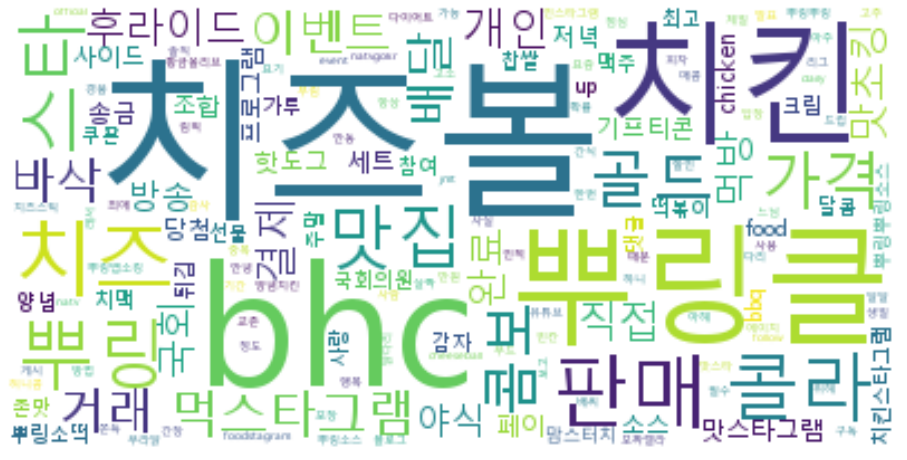

In [28]:
wordcloude_img = WordCloud(background_color = 'white', max_words=150, font_path=font_path).generate_from_frequencies(textdict)
plt.figure(figsize=(16,16))
plt.imshow(wordcloude_img, interpolation='bilinear')
plt.axis('off')
plt.show()